<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Spatial-weights" data-toc-modified-id="Spatial-weights-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Spatial weights</a></span></li><li><span><a href="#Standardizing-W-matrices" data-toc-modified-id="Standardizing-W-matrices-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Standardizing <code>W</code> matrices</a></span></li><li><span><a href="#Spatial-Lag" data-toc-modified-id="Spatial-Lag-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Spatial Lag</a></span></li><li><span><a href="#Spatial-autocorrelation-and-Exploratory-Spatial-Data-Analysis" data-toc-modified-id="Spatial-autocorrelation-and-Exploratory-Spatial-Data-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Spatial autocorrelation and Exploratory Spatial Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Moran-Plot" data-toc-modified-id="Moran-Plot-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Moran Plot</a></span></li><li><span><a href="#Moran's-I" data-toc-modified-id="Moran's-I-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Moran's I</a></span></li><li><span><a href="#Local-Spatial-autocorrelation" data-toc-modified-id="Local-Spatial-autocorrelation-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Local Spatial autocorrelation</a></span></li></ul></li></ul></div>

In [1]:
import os
from IPython.display import IFrame, HTML
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import pysal as ps
from shapely.geometry import Point, Polygon

C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
gdal_data = os.environ['GDAL_DATA']

In [3]:
# os.environ
# os.chdir('Documents/repos/geo')
os.listdir()

['.git',
 '.gitattributes',
 '.gitignore',
 '.idea',
 '.ipynb_checkpoints',
 'arcgis.ipynb',
 'choropleth-map-example.png',
 'data',
 'geo_doodle.py',
 'my_functions_geo.py',
 'new_workflow.ipynb',
 'parking_Toronto.ipynb',
 'README.md',
 'Teranet_GTHA_DA_investigating_pins.ipynb',
 'Teranet_GTHA_DA_spatial_join.ipynb',
 'Teranet_GTHA_DA_workflow.ipynb']

In [3]:
from my_functions_geo import column_kde
from my_functions_geo import series_choropleth
from my_functions_geo import map_neighbours

In [41]:
def map_neighbours(gdf, wm, focus_id, focus_rad=0.025, geometry_col='geometry',
                   plot_title='Neighbours',
                   plot_buffer=False, buffer_rad=0, buffer_color='red', buffer_alpha=0.3,
                   base_color='black', base_linewidth=0.1, base_alpha=1,
                   focus_color='red', focus_linewidth=0, focus_alpha=1,
                   neighs_color='lime', neighs_linewidth=0, neighs_alpha=1):
    """
    map focus polygon from a GeoDataFrame and its neighbourhood
    :param buffer_alpha:
    :param buffer_color:
    :param buffer_rad:
    :param plot_buffer:
    :param plot_title:
    :param neighs_alpha:
    :param neighs_linewidth:
    :param neighs_color:
    :param focus_alpha:
    :param focus_linewidth:
    :param focus_color:
    :param base_alpha:
    :param base_linewidth:
    :param base_color:
    :param gdf: GeoDataFrame
                GeoDataFrame with polygons of interest
    :param wm:  PySal weight matrix
                weight matrix generated in PySal for GeoDataFrame
    :param focus_id: int or string
                index of the polygon to highlight from the GeoDataFrame
    :param focus_rad: float
                zoom radius for the map
    :param geometry_col: string
                name of the geometry column in the GeoDataFrame
    :return: None, plots a map
    """
    print(plot_title)
    print("Number of observations",
          wm.n)
    print("Average number of neighbors",
          wm.mean_neighbors)
    print("Min number of neighbors",
          wm.min_neighbors)
    print("Max number of neighbors",
          wm.max_neighbors)
    print("No of islands (observations disconnected):",
          len(wm.islands))
    card = pd.Series(wm.cardinalities)
    f, ax = plt.subplots(1)
    sns.distplot(card, rug=True, bins=20)
    ax.set_title("Distribution of cardinalities for " + plot_title)
    plt.show()
    # Setup figure
    f, ax = plt.subplots(1, figsize=(6, 6))
    # Plot base layer of polygons
    gdf.plot(ax=ax, facecolor=base_color,
             linewidth=base_linewidth, alpha=base_alpha)
    # Select focal polygon
    focus = gdf.loc[[focus_id], [geometry_col]]
    # Plot focal polygon
    focus.plot(facecolor=focus_color, linewidth=focus_linewidth,
               alpha=focus_alpha, ax=ax)
    if plot_buffer:
        focus.centroid.plot(ax=ax)
        focus.centroid.buffer(buffer_rad).plot(ax=ax,
                                               color=buffer_color,
                                               alpha=buffer_alpha)
    # Plot neighbors
    neis = gdf.loc[list(wm[focus_id].keys())]
    neis.plot(ax=ax, facecolor=neighs_color,
              linewidth=neighs_linewidth, alpha=neighs_alpha)
    # Title
    f.suptitle(plot_title + " of {0}".format(focus_id))
    # Style and display on screen
    ax.set_ylim(focus.centroid.y[0] - focus_rad, focus.centroid.y[0] + focus_rad)
    ax.set_xlim(focus.centroid.x[0] - focus_rad, focus.centroid.x[0] + focus_rad)
    plt.show()


In [71]:
def plot_moran(value_slag, value, plot_title=""):
    """
    plot a Moran plot for analyzing spatial autocorrelation 
    """
    # Plot values
    sns.jointplot(x=value_slag, 
                  y=value, 
                  kind="reg")
    ax = plt.gca()
    # Add vertical and horizontal lines
    ax.axvline(0, c='k', alpha=0.5)
    ax.axhline(0, c='k', alpha=0.5)
    plt.suptitle(plot_title + " Moran plot for spatial autocorrelation")
    # Display
    plt.show()

In [105]:
def moran_i(series, wm, title=""):
    """
    compute and print Moran's I and its associated p-value
    from a Series and its associated weight matrix
    """
    mi = ps.explore.esda.moran.Moran(series, wm)
    print("Moran I for " + title)
    print("Moran I value = " + str(mi.I))
    print("Associated p-value = " + str(mi.p_sim))

In [157]:
def map_lisa(gdf, sgn_col='significant', quad_col='quadrant', plot_title="",
             zoom=0, left_lim=0, bottom_lim=0):
    """
    map LISA quadrants from supplied GeoDataFrame
    :param bottom_lim: 
    :param left_lim: 
    :param zoom: 
    :param plot_title: 
    :param gdf: 
    :param sgn_col: 
    :param quad_col: 
    :return: 
    """
    # Setup the figure and axis
    f, ax = plt.subplots(1, figsize=(9, 9))
    # Plot insignificant clusters
    ns = gdf.loc[gdf[sgn_col] == False, 'geometry']
    ns.plot(ax=ax, color='k')
    # Plot HH clusters
    hh = gdf.loc[(gdf[quad_col] == 1) & (gdf[sgn_col] == True), 'geometry']
    hh.plot(ax=ax, color='red')
    # Plot LL clusters
    ll = gdf.loc[(gdf[quad_col] == 3) & (gdf[sgn_col] == True), 'geometry']
    ll.plot(ax=ax, color='blue')
    # Plot LH clusters
    lh = gdf.loc[(gdf[quad_col] == 2) & (gdf[sgn_col] == True), 'geometry']
    lh.plot(ax=ax, color='#83cef4')
    # Plot HL clusters
    hl = gdf.loc[(gdf[quad_col] == 4) & (gdf[sgn_col] == True), 'geometry']
    hl.plot(ax=ax, color='#e59696')
    # Style and draw
    f.suptitle('LISA' + plot_title, size=20)
    f.set_facecolor('white')
    if zoom:
        ax.set_xlim(left_lim, left_lim + zoom)
        ax.set_ylim(bottom_lim, bottom_lim + zoom)
    plt.show()


In [4]:
# da_geo_source = 'https://opendata.arcgis.com/datasets/9d262f8a576842fbb2afbc8c51a64178_1.geojson'
da_geo_source = 'data/Profile_of_Income_by_Dissemination_Area__Greater_Toronto_Area_2016_Census.geojson'
da_income_gdf = gpd.read_file(da_geo_source)
print("GeoDataFrame 'da_income_gdf' with profile of income by dissimination areas created!")

GeoDataFrame 'da_income_gdf' with profile of income by dissimination areas created!


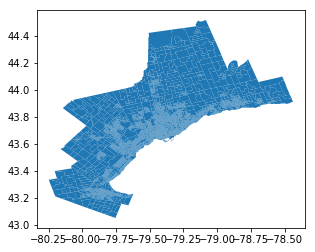

In [5]:
da_income_gdf.plot();

In [6]:
# verify the path to Teranet dataset
save_file_path = 'data/HHSaleHistory_cleaned_v0.9_GTHA_DA.csv'
# read Teranet dataset with a column containing Dissimination Areas id
teranet_da_df = pd.read_csv(save_file_path)
# drop unnecessary columns
teranet_da_df.drop(['Unnamed: 0', 'index'], axis=1, inplace=True)
# covert 'registration_date' to datetime data format
teranet_da_df['registration_date'] = pd.to_datetime(teranet_da_df['registration_date'])
teranet_da_df = teranet_da_df.set_index('registration_date')
teranet_da_df = teranet_da_df.sort_index()
print("Teranet sales data with Dissimination Areas info was loaded into DataFrame 'teranet_da_df'!")

Teranet sales data with Dissimination Areas info was loaded into DataFrame 'teranet_da_df'!


In [7]:
# group Teranet dataset by Dissimination Area id
da_groups = teranet_da_df.groupby(by='da_id')

In [8]:
# Make an aggregate (count of all records) from Teranet data
teranet_da_agg_count = pd.DataFrame(da_groups['x'].count())
print("Done!")

Done!


In [9]:
# key to be used for the JOIN in Teranet DA groups -- 'index'
teranet_da_agg_count.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182],
           dtype='int64', name='da_id', length=9168)

In [10]:
# Key to be used for the JOIN in gdf with Dissimination Areas -- column 'OBJECTID'
da_income_gdf[['OBJECTID']].sort_values(by='OBJECTID')

,OBJECTID
3000,1
3001,2
3002,3
3003,4
3004,5
3005,6
3006,7
3007,8
3008,9
3009,10


In [11]:
# perform the JOIN of Teranet aggregate with DA gdf
teranet_column_name = 'x'
new_column_name = 'teranet_sales_count'
# save projection information from GeoDataFrame with DAs
crs = da_income_gdf.crs
# JOIN Teranet aggregate to GeoDataFrame with DAs (produces a DataFrame)
teranet_da_gdf = pd.merge(teranet_da_agg_count,
                          da_income_gdf,
                          left_on=teranet_da_agg_count.index,
                          right_on=da_income_gdf['OBJECTID'])
# rename the column containing aggregate Teranet information
teranet_da_gdf.rename(columns={teranet_column_name:new_column_name}, inplace=True)
# convert DataFrame to GeoDataFrame
teranet_da_gdf = gpd.GeoDataFrame(teranet_da_gdf, 
                                  geometry=teranet_da_gdf['geometry'])
# add projection information to the new GeoDataFrame
teranet_da_gdf.crs = crs
print("Teranet data aggregate JOINED to GeoDataFrame with Dissimination Areas!")

Teranet data aggregate JOINED to GeoDataFrame with Dissimination Areas!


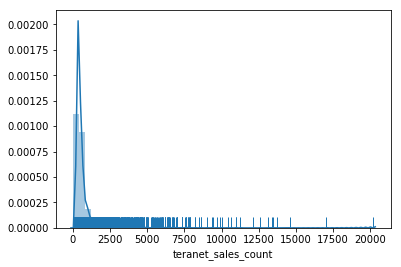

In [12]:
sns.distplot(teranet_da_gdf['teranet_sales_count'], rug=True)

In [13]:
teranet_da_gdf['teranet_sales_count'].sum()

6062853

## Spatial weights
One of the key pieces in spatial analysis are spatial weights matrices. These are structured sets of numbers that formalize geographical relationships between the observations in a dataset. Essentially, a spatial weights matrix of a given geography is a positive definite matrix of dimensions $N$ by $N$, where $N$ is the total number of observations:

$W = \left(\begin{array}{cccc}
0 & w_{12} & \dots & w_{1N} \\
w_{21} & \ddots & w_{ij} & \vdots \\
\vdots & w_{ji} & 0 & \vdots \\
w_{N1} & \dots & \dots & 0 
\end{array} \right)$

where each cell $w_{ij}$ contains a value that represents the degree of spatial contact or interaction between observations $i$ and $j$. A fundamental concept in this context is that of *neighbor* and *neighborhood*. By convention, elements in the diagonal ($w_{ij}$) are set to zero. A *neighbor* of a given observation $i$ is another observation with which $i$ has some degree of connection. In terms of $W$, $i$ and $j$ are thus neighbors if $w_{ij} > 0$. Following this logic, the neighborhood of $i$ will be the set of observations in the system with which it has certain connection, or those observations with a weight greater than zero.

There are several ways to create such matrices, and many more to transform them so they contain an accurate representation that aligns with the way we understand spatial interactions between the elements of a system. 

In [14]:
w_queen = ps.lib.weights.Queen.from_dataframe(teranet_da_gdf)
w_queen.remap_ids(teranet_da_gdf.index)
w_queen

C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\pysal\lib\weights\contiguity.py:184: UserWarning: There is one disconnected observation (no neighbors).
Island id: 1298
  W.__init__(self, neighbors, ids=ids, **kw)


Queen neighbors
Number of observations 9168
Average number of neighbors 6.422993019197207
Min number of neighbors 0
Max number of neighbors 31
No of islands: (observations disconnected) 1


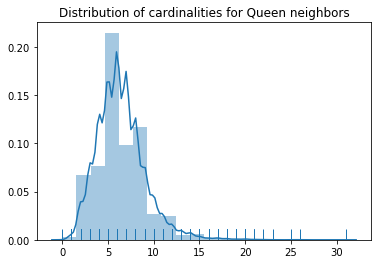

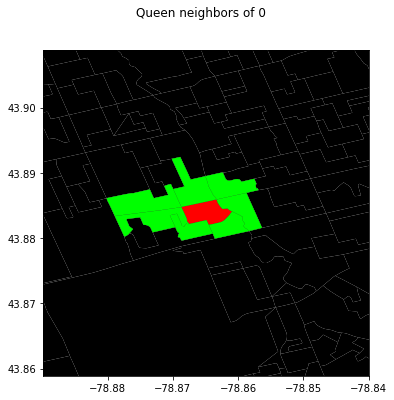

In [29]:
focus_da_id = 0
plot_title = "Queen neighbors"

map_neighbours(teranet_da_gdf, w_queen, 0, plot_title=plot_title)

In [31]:
# KNN neighbours
k = 20
knn = ps.lib.weights.KNN.from_dataframe(teranet_da_gdf,
                                          k=k)
knn.remap_ids(teranet_da_gdf.index)
knn

KNN (k=20) neighbors
Number of observations 9168
Average number of neighbors 20.0
Min number of neighbors 20
Max number of neighbors 20
No of islands: (observations disconnected) 0


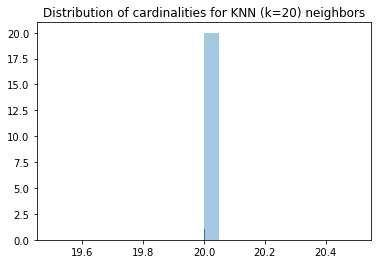

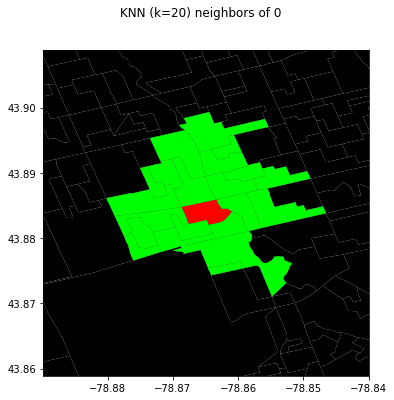

In [33]:
focus_da_id = 0
plot_title = "KNN (k={0}) neighbors".format(k)

map_neighbours(teranet_da_gdf, knn, 0, plot_title=plot_title)

In [34]:
# Distance band neighbours (binary)
dist = 1000 # buffer in m
dist_deg = dist / (1000 * 112.32) # convert to degrees of WGS 84
w_dist1kmB = ps.lib.weights.DistanceBand.from_dataframe(teranet_da_gdf, 
                                                        dist_deg, 
                                                        binary=True)
w_dist1kmB

C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 549 disconnected observations 
  Island ids: 38, 39, 61, 85, 96, 106, 116, 117, 144, 145, 149, 154, 155, 161, 162, 163, 164, 165, 166, 167, 168, 204, 205, 206, 217, 218, 219, 229, 230, 231, 232, 233, 234, 235, 240, 314, 356, 413, 438, 472, 498, 507, 524, 536, 556, 558, 559, 560, 597, 598, 599, 629, 630, 631, 632, 633, 634, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 695, 696, 697, 698, 699, 710, 711, 738, 739, 740, 741, 742, 743, 744, 746, 766, 767, 768, 769, 770, 809, 810, 811, 812, 813, 836, 837, 838, 839, 840, 841, 843, 914, 915, 916, 955, 956, 989, 990, 991, 992, 996, 997, 1013, 1014, 1019, 1039, 1054, 1055, 1062, 1075, 1076, 1077, 1078, 1089, 1090, 1100, 1107, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1131, 1186, 1194, 1195, 1219, 1220, 1221, 1237, 1238, 1245, 1254, 1255, 1275, 1276, 1277, 1278, 1291, 1298, 1334, 1335, 1336, 1356, 1365, 1373, 1379, 1382, 13

Distance band, binary (dist=1000m) neighbors
Number of observations 9168
Average number of neighbors 12.836387434554974
Min number of neighbors 0
Max number of neighbors 58
No of islands (observations disconnected): 549


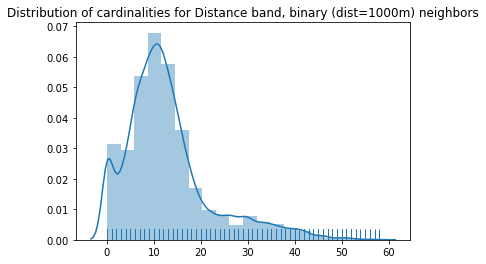

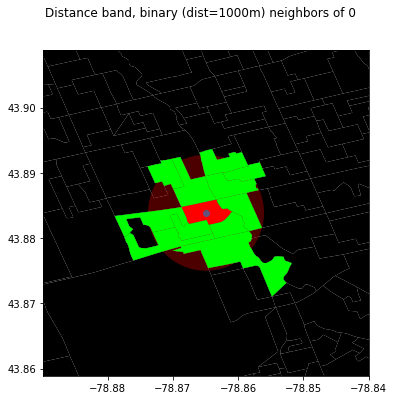

In [42]:
focus_da_id = 0
plot_title = "Distance band, binary (dist={0}m) neighbors".format(dist)

map_neighbours(teranet_da_gdf, w_dist1kmB, 0, plot_title=plot_title,
               plot_buffer=True, buffer_rad=dist_deg)

In [43]:
# Distance band neighbours (binary)
dist = 2000 # buffer in m
dist_deg = dist / (1000 * 112.32) # convert to degrees of WGS 84
w_dist2kmB = ps.lib.weights.DistanceBand.from_dataframe(teranet_da_gdf, 
                                                        dist_deg, 
                                                        binary=True)
w_dist2kmB

C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 325 disconnected observations 
  Island ids: 38, 85, 106, 116, 144, 145, 149, 154, 155, 161, 162, 163, 165, 166, 167, 168, 204, 205, 206, 217, 218, 230, 231, 240, 472, 524, 536, 559, 560, 597, 598, 630, 631, 634, 645, 647, 648, 649, 650, 652, 653, 654, 655, 656, 696, 698, 710, 711, 738, 739, 740, 741, 742, 743, 766, 769, 770, 809, 810, 811, 812, 813, 836, 837, 838, 839, 840, 914, 915, 916, 955, 956, 989, 990, 991, 992, 996, 1013, 1039, 1054, 1055, 1076, 1077, 1078, 1090, 1100, 1107, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1186, 1219, 1220, 1221, 1255, 1276, 1291, 1334, 1335, 1336, 1356, 1365, 1373, 1379, 1382, 1405, 1408, 1503, 1508, 1516, 1532, 1541, 1682, 1691, 1724, 1751, 1757, 1758, 1790, 1816, 1817, 1840, 1856, 1857, 1869, 1870, 1886, 1887, 1888, 1899, 1917, 1918, 1928, 1930, 1933, 1962, 1963, 1975, 1991, 2022, 2055, 2082, 2094, 2095, 2096, 2097, 2098, 2132, 2140, 2

Distance band, binary (dist=2000m) neighbors
Number of observations 9168
Average number of neighbors 46.84424083769633
Min number of neighbors 0
Max number of neighbors 175
No of islands (observations disconnected): 325


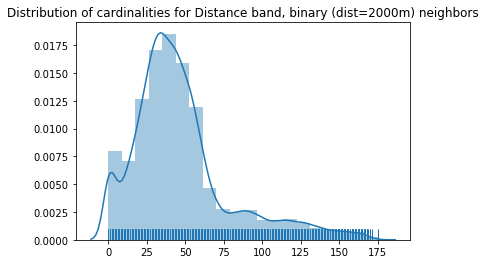

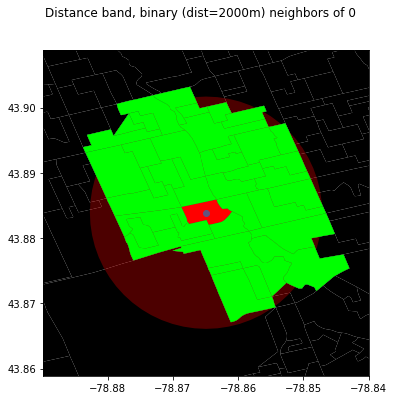

In [44]:
focus_da_id = 0
plot_title = "Distance band, binary (dist={0}m) neighbors".format(dist)

map_neighbours(teranet_da_gdf, w_dist2kmB, 0, plot_title=plot_title,
               plot_buffer=True, buffer_rad=dist_deg)

In [45]:
# Distance band neighbours (continuous)
dist = 1000 # buffer in m
dist_deg = dist / (1000 * 112.32) # convert to degrees of WGS 84
w_dist1kmC = ps.lib.weights.DistanceBand.from_dataframe(teranet_da_gdf, 
                                                        dist_deg, 
                                                        binary=False)
w_dist1kmC

C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 549 disconnected observations 
  Island ids: 38, 39, 61, 85, 96, 106, 116, 117, 144, 145, 149, 154, 155, 161, 162, 163, 164, 165, 166, 167, 168, 204, 205, 206, 217, 218, 219, 229, 230, 231, 232, 233, 234, 235, 240, 314, 356, 413, 438, 472, 498, 507, 524, 536, 556, 558, 559, 560, 597, 598, 599, 629, 630, 631, 632, 633, 634, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 695, 696, 697, 698, 699, 710, 711, 738, 739, 740, 741, 742, 743, 744, 746, 766, 767, 768, 769, 770, 809, 810, 811, 812, 813, 836, 837, 838, 839, 840, 841, 843, 914, 915, 916, 955, 956, 989, 990, 991, 992, 996, 997, 1013, 1014, 1019, 1039, 1054, 1055, 1062, 1075, 1076, 1077, 1078, 1089, 1090, 1100, 1107, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1131, 1186, 1194, 1195, 1219, 1220, 1221, 1237, 1238, 1245, 1254, 1255, 1275, 1276, 1277, 1278, 1291, 1298, 1334, 1335, 1336, 1356, 1365, 1373, 1379, 1382, 13

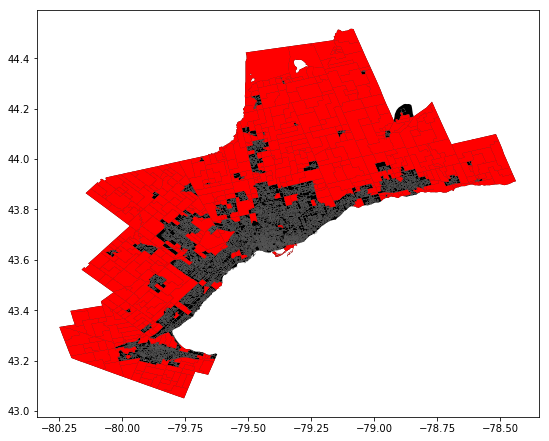

In [81]:
# map islands
ax = teranet_da_gdf.plot(color='k', figsize=(9, 9))
teranet_da_gdf.loc[w_dist1kmB.islands, :].plot(color='red', ax=ax);

In [47]:
# Distance band neighbours (continuous)
dist = 2000 # buffer in m
dist_deg = dist / (1000 * 112.32) # convert to degrees of WGS 84
w_dist2kmC = ps.lib.weights.DistanceBand.from_dataframe(teranet_da_gdf, 
                                                        dist_deg, 
                                                        binary=False)
w_dist2kmC

C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 325 disconnected observations 
  Island ids: 38, 85, 106, 116, 144, 145, 149, 154, 155, 161, 162, 163, 165, 166, 167, 168, 204, 205, 206, 217, 218, 230, 231, 240, 472, 524, 536, 559, 560, 597, 598, 630, 631, 634, 645, 647, 648, 649, 650, 652, 653, 654, 655, 656, 696, 698, 710, 711, 738, 739, 740, 741, 742, 743, 766, 769, 770, 809, 810, 811, 812, 813, 836, 837, 838, 839, 840, 914, 915, 916, 955, 956, 989, 990, 991, 992, 996, 1013, 1039, 1054, 1055, 1076, 1077, 1078, 1090, 1100, 1107, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1186, 1219, 1220, 1221, 1255, 1276, 1291, 1334, 1335, 1336, 1356, 1365, 1373, 1379, 1382, 1405, 1408, 1503, 1508, 1516, 1532, 1541, 1682, 1691, 1724, 1751, 1757, 1758, 1790, 1816, 1817, 1840, 1856, 1857, 1869, 1870, 1886, 1887, 1888, 1899, 1917, 1918, 1928, 1930, 1933, 1962, 1963, 1975, 1991, 2022, 2055, 2082, 2094, 2095, 2096, 2097, 2098, 2132, 2140, 2

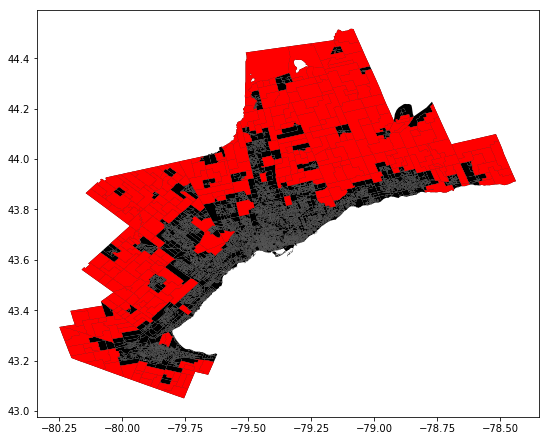

In [80]:
# map islands
ax = teranet_da_gdf.plot(color='k', figsize=(9, 9))
teranet_da_gdf.loc[w_dist2kmB.islands, :].plot(color='red', ax=ax);

In [82]:
t_da_gdf_noisl = teranet_da_gdf.drop(w_dist2kmB.islands)
# Distance band neighbours (continuous)
dist = 2000 # buffer in m
dist_deg = dist / (1000 * 112.32) # convert to degrees of WGS 84
w_dist2kmC_ni = ps.lib.weights.DistanceBand.from_dataframe(t_da_gdf_noisl, 
                                                        dist_deg, 
                                                        binary=False)
w_dist2kmC_ni

C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 37 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 37 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


## Standardizing `W` matrices

In the context of many spatial analysis techniques, a spatial weights matrix with raw values (e.g. ones and zeros for the binary case) is not always the best suiting one for analysis and some sort of transformation is required. This implies modifying each weight so they conform to certain rules. `PySAL` has transformations baked right into the `W` object, so it is possible to check the state of an object as well as to modify it.

`PySAL` supports the following transformations:

* `O`: original, returning the object to the initial state.
* `B`: binary, with every neighbor having assigned a weight of one.
* `R`: row, with all the neighbors of a given observation adding up to one.
* `V`: variance stabilizing, with the sum of all the weights being constrained to the number of observations.

In [83]:
# Row-standardize the weight matrix
w_queen.transform = 'R'
knn.transform = 'R'
w_dist1kmB.transform = 'R'
w_dist2kmB.transform = 'R'
w_dist1kmC.transform = 'R'
w_dist2kmC.transform = 'R'
w_dist2kmC_ni.transform = 'R'

## Spatial Lag

One of the most direct applications of spatial weight matrices is the so-called *spatial lag*. The spatial lag of a given variable is the product of a spatial weight matrix and the variable itself:

$$Y_{sl} = W Y$$

where $Y$ is a Nx1 vector with the values of the variable. Recall that the product of a matrix and a vector equals the sum of a row by column element multiplication for the resulting value of a given row. In terms of the spatial lag:

$$y_{sl-i} = \displaystyle \sum_j w_{ij} y_j$$

If we are using row-standardized weights, $w_{ij}$ becomes a proportion between zero and one, and $y_{sl-i}$ can be seen as the average value of $Y$ in the neighborhood of $i$.

The spatial lag is a key element of many spatial analysis techniques and, as such, it is fully supported in `PySAL`. To compute the spatial lag of a given variable:

In [48]:
column = 'teranet_sales_count'

# Compute spatial lag of column values
w_queen_score = ps.lib.weights.lag_spatial(w_queen, teranet_da_gdf[column])
knn_score = ps.lib.weights.lag_spatial(knn, teranet_da_gdf[column])
dist1kmB_score = ps.lib.weights.lag_spatial(w_dist1kmB, teranet_da_gdf[column])
dist2kmB_score = ps.lib.weights.lag_spatial(w_dist2kmB, teranet_da_gdf[column])
dist1kmC_score = ps.lib.weights.lag_spatial(w_dist1kmC, teranet_da_gdf[column])
dist2kmC_score = ps.lib.weights.lag_spatial(w_dist2kmC, teranet_da_gdf[column])

teranet_da_gdf['w_queen_score'] = w_queen_score
teranet_da_gdf['w_knn_score'] = knn_score
teranet_da_gdf['w_dist_1kmB_score'] = dist1kmB_score
teranet_da_gdf['w_dist_2kmB_score'] = dist2kmB_score
teranet_da_gdf['w_dist_1kmC_score'] = dist1kmC_score
teranet_da_gdf['w_dist_2kmC_score'] = dist2kmC_score

('WARNING: ', 1298, ' is an island (no neighbors)')
('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WARNING: ', 61, ' is an island (no neighbors)')
('WARNING: ', 85, ' is an island (no neighbors)')
('WARNING: ', 96, ' is an island (no neighbors)')
('WARNING: ', 106, ' is an island (no neighbors)')
('WARNING: ', 116, ' is an island (no neighbors)')
('WARNING: ', 117, ' is an island (no neighbors)')
('WARNING: ', 144, ' is an island (no neighbors)')
('WARNING: ', 145, ' is an island (no neighbors)')
('WARNING: ', 149, ' is an island (no neighbors)')
('WARNING: ', 154, ' is an island (no neighbors)')
('WARNING: ', 155, ' is an island (no neighbors)')
('WARNING: ', 161, ' is an island (no neighbors)')
('WARNING: ', 162, ' is an island (no neighbors)')
('WARNING: ', 163, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 165, ' is an island (no neighbors)')
('WARNING: ', 166, ' is an island (

('WARNING: ', 996, ' is an island (no neighbors)')
('WARNING: ', 1013, ' is an island (no neighbors)')
('WARNING: ', 1039, ' is an island (no neighbors)')
('WARNING: ', 1054, ' is an island (no neighbors)')
('WARNING: ', 1055, ' is an island (no neighbors)')
('WARNING: ', 1076, ' is an island (no neighbors)')
('WARNING: ', 1077, ' is an island (no neighbors)')
('WARNING: ', 1078, ' is an island (no neighbors)')
('WARNING: ', 1090, ' is an island (no neighbors)')
('WARNING: ', 1100, ' is an island (no neighbors)')
('WARNING: ', 1107, ' is an island (no neighbors)')
('WARNING: ', 1113, ' is an island (no neighbors)')
('WARNING: ', 1114, ' is an island (no neighbors)')
('WARNING: ', 1115, ' is an island (no neighbors)')
('WARNING: ', 1116, ' is an island (no neighbors)')
('WARNING: ', 1117, ' is an island (no neighbors)')
('WARNING: ', 1118, ' is an island (no neighbors)')
('WARNING: ', 1119, ' is an island (no neighbors)')
('WARNING: ', 1120, ' is an island (no neighbors)')
('WARNING: ',

('WARNING: ', 7493, ' is an island (no neighbors)')
('WARNING: ', 7494, ' is an island (no neighbors)')
('WARNING: ', 7527, ' is an island (no neighbors)')
('WARNING: ', 7528, ' is an island (no neighbors)')
('WARNING: ', 7529, ' is an island (no neighbors)')
('WARNING: ', 7530, ' is an island (no neighbors)')
('WARNING: ', 7564, ' is an island (no neighbors)')
('WARNING: ', 7565, ' is an island (no neighbors)')
('WARNING: ', 7566, ' is an island (no neighbors)')
('WARNING: ', 7567, ' is an island (no neighbors)')
('WARNING: ', 7578, ' is an island (no neighbors)')
('WARNING: ', 7579, ' is an island (no neighbors)')
('WARNING: ', 7580, ' is an island (no neighbors)')
('WARNING: ', 7581, ' is an island (no neighbors)')
('WARNING: ', 7593, ' is an island (no neighbors)')
('WARNING: ', 7598, ' is an island (no neighbors)')
('WARNING: ', 7599, ' is an island (no neighbors)')
('WARNING: ', 7611, ' is an island (no neighbors)')
('WARNING: ', 7612, ' is an island (no neighbors)')
('WARNING: '

('WARNING: ', 6713, ' is an island (no neighbors)')
('WARNING: ', 6714, ' is an island (no neighbors)')
('WARNING: ', 6741, ' is an island (no neighbors)')
('WARNING: ', 6742, ' is an island (no neighbors)')
('WARNING: ', 6800, ' is an island (no neighbors)')
('WARNING: ', 6864, ' is an island (no neighbors)')
('WARNING: ', 6882, ' is an island (no neighbors)')
('WARNING: ', 6883, ' is an island (no neighbors)')
('WARNING: ', 6886, ' is an island (no neighbors)')
('WARNING: ', 6894, ' is an island (no neighbors)')
('WARNING: ', 6895, ' is an island (no neighbors)')
('WARNING: ', 6896, ' is an island (no neighbors)')
('WARNING: ', 6899, ' is an island (no neighbors)')
('WARNING: ', 6930, ' is an island (no neighbors)')
('WARNING: ', 6940, ' is an island (no neighbors)')
('WARNING: ', 7049, ' is an island (no neighbors)')
('WARNING: ', 7065, ' is an island (no neighbors)')
('WARNING: ', 7086, ' is an island (no neighbors)')
('WARNING: ', 7090, ' is an island (no neighbors)')
('WARNING: '

('WARNING: ', 5041, ' is an island (no neighbors)')
('WARNING: ', 5468, ' is an island (no neighbors)')
('WARNING: ', 6089, ' is an island (no neighbors)')
('WARNING: ', 6090, ' is an island (no neighbors)')
('WARNING: ', 6091, ' is an island (no neighbors)')
('WARNING: ', 6092, ' is an island (no neighbors)')
('WARNING: ', 6106, ' is an island (no neighbors)')
('WARNING: ', 6107, ' is an island (no neighbors)')
('WARNING: ', 6108, ' is an island (no neighbors)')
('WARNING: ', 6154, ' is an island (no neighbors)')
('WARNING: ', 6155, ' is an island (no neighbors)')
('WARNING: ', 6156, ' is an island (no neighbors)')
('WARNING: ', 6157, ' is an island (no neighbors)')
('WARNING: ', 6195, ' is an island (no neighbors)')
('WARNING: ', 6200, ' is an island (no neighbors)')
('WARNING: ', 6201, ' is an island (no neighbors)')
('WARNING: ', 6231, ' is an island (no neighbors)')
('WARNING: ', 6332, ' is an island (no neighbors)')
('WARNING: ', 6349, ' is an island (no neighbors)')
('WARNING: '

## Spatial autocorrelation and Exploratory Spatial Data Analysis

Spatial autocorrelation has to do with the degree to which the similarity in values between observations in a dataset is related to the similarity in locations of such observations. Not completely unlike the traditional correlation between two variables -which informs us about how the values in one variable change as a function of those in the other- and analogous to its time-series counterpart -which relates the value of a variable at a given point in time with those in previous periods-, spatial autocorrelation relates the value of the variable of interest in a given location, with values of the same variable in surrounding locations.

A key idea in this context is that of spatial randomness: a situation in which the location of an observation gives no information whatsoever about its value. In other words, a variable is spatially random if it is distributed following no discernible pattern over space. Spatial autocorrelation can thus be formally defined as the "absence of spatial randomness", which gives room for two main classes of autocorrelation, similar to the traditional case: *positive* spatial autocorrelation, when similar values tend to group together in similar locations; and *negative* spatial autocorrelation, in cases where similar values tend to be dispersed and further apart from each other.

To explore spatial autocorrelation in a given dataset, investigating its presence, nature, and strength, a set of tools collectively known as Exploratory Spatial Data Analysis (ESDA) can be used. The range of ESDA methods is very wide and spans from less sophisticated approaches like choropleths and general table querying, to more advanced and robust methodologies that include statistical inference and an explicit recognition of the geographical dimension of the data. The purpose of this session is to dip our toes into the latter group.

ESDA techniques are usually divided into two main groups: tools to analyze *global*, and *local* spatial autocorrelation. The former consider the overall trend that the location of values follows, and makes possible statements about the **degree of *clustering*** in the dataset. Tools for *local* spatial autocorrelation instead focus on spatial instability: the departure of parts of a map from the general trend. The idea here is that, even though there is a given trend for the data in terms of the nature and strength of spatial association, some particular areas can diverege quite substantially from the general pattern. Regardless of the overall degree of concentration in the values, we can observe pockets of unusually high (low) values close to other high (low) values, in what we will call hot(cold)spots. Additionally, it is also possible to observe some high (low) values surrounded by low (high) values, and we will name these "spatial outliers". The main technique used here to explore local spatial autocorrelation is the Local Indicators of Spatial Association (LISA).

### Moran Plot

The Moran Plot is a graphical way to start exploring the concept of spatial autocorrelation, and it is a good application of spatial weight matrices and the spatial lag. In essence, it is a standard scatter plot in which a given variable is plotted against *its own* spatial lag. Usually, a fitted line is added to include more information.

In order to easily compare different scatter plots and spot outlier observations, it is common practice to standardize the values of the variable before computing its spatial lag and plotting it. This can be accomplished by substracting the average value and dividing the result by the standard deviation:

$z_i = \dfrac{y - \bar{y}}{\sigma_y}$

where $z_i$ is the standardized version of $y_i$, $\bar{y}$ is the average of the variable, and $\sigma$ its standard deviation.

Creating a standardized Moran Plot implies that average values are centered in the plot (as they are zero when standardized) and dispersion is expressed in standard deviations, with the rule of thumb of values greater or smaller than two standard deviations being *outliers*. A standardized Moran Plot also partitions the space into four quadrants that represent different situations:

1. High-High (*HH*): values above average surrounded by values above average.
1. Low-Low (*LL*): values below average surrounded by values below average.
1. High-Low (*HL*): values above average surrounded by values below average.
1. Low-High (*LH*): values below average surrounded by values above average.

In [57]:
def standardize(series):
    """
    compute z-scores based on provided series
    """
    return (series - series.mean()) / series.std()

std_col = 'std_sales_count'
teranet_da_gdf[std_col] = standardize(teranet_da_gdf[column])

# Compute spatial lag of column values
std_w_queen_score = ps.lib.weights.lag_spatial(w_queen, teranet_da_gdf[std_col])
std_knn_score = ps.lib.weights.lag_spatial(knn, teranet_da_gdf[std_col])
std_dist1kmB_score = ps.lib.weights.lag_spatial(w_dist1kmB, teranet_da_gdf[std_col])
std_dist2kmB_score = ps.lib.weights.lag_spatial(w_dist2kmB, teranet_da_gdf[std_col])
std_dist1kmC_score = ps.lib.weights.lag_spatial(w_dist1kmC, teranet_da_gdf[std_col])
std_dist2kmC_score = ps.lib.weights.lag_spatial(w_dist2kmC, teranet_da_gdf[std_col])

teranet_da_gdf['std_w_queen_score'] = std_w_queen_score
teranet_da_gdf['std_w_knn_score'] = std_knn_score
teranet_da_gdf['std_w_dist_1kmB_score'] = std_dist1kmB_score
teranet_da_gdf['std_w_dist_2kmB_score'] = std_dist2kmB_score
teranet_da_gdf['std_w_dist_1kmC_score'] = std_dist1kmC_score
teranet_da_gdf['std_w_dist_2kmC_score'] = std_dist2kmC_score

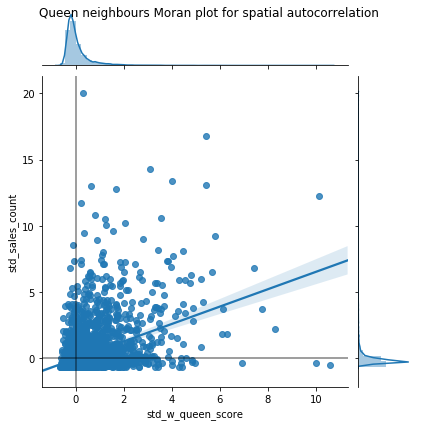

In [70]:
plot_moran(teranet_da_gdf['std_w_queen_score'], teranet_da_gdf[std_col], plot_title="Queen neighbours")

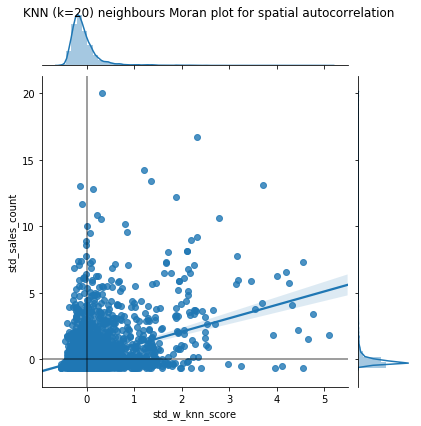

In [72]:
plot_moran(teranet_da_gdf['std_w_knn_score'], teranet_da_gdf[std_col], plot_title="KNN (k={0}) neighbours".format(k))

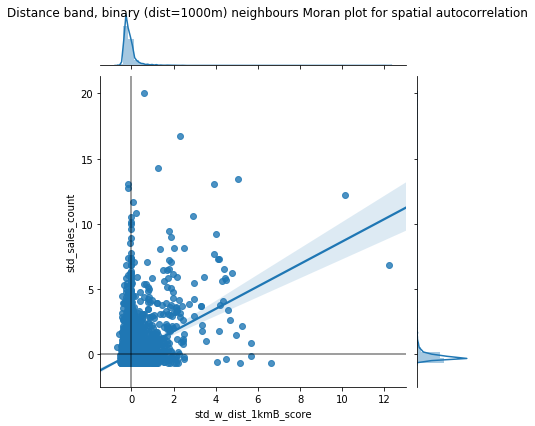

In [73]:
plot_moran(teranet_da_gdf['std_w_dist_1kmB_score'], teranet_da_gdf[std_col], 
           plot_title="Distance band, binary (dist=1000m) neighbours")

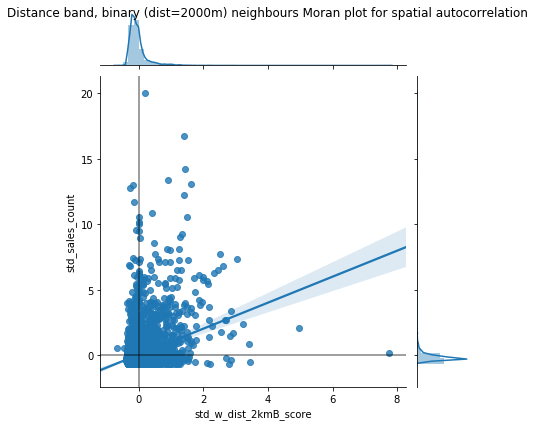

In [74]:
plot_moran(teranet_da_gdf['std_w_dist_2kmB_score'], teranet_da_gdf[std_col], 
           plot_title="Distance band, binary (dist=2000m) neighbours")

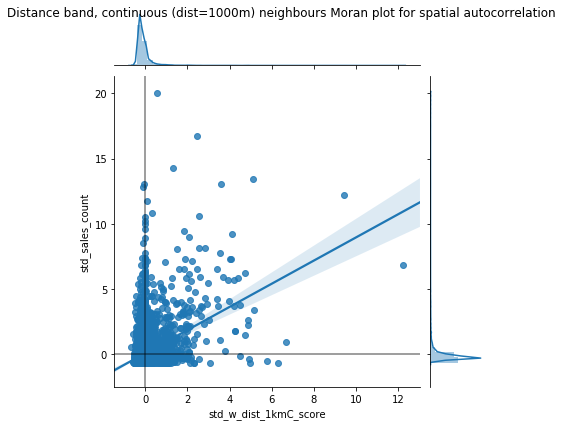

In [75]:
plot_moran(teranet_da_gdf['std_w_dist_1kmC_score'], teranet_da_gdf[std_col], 
           plot_title="Distance band, continuous (dist=1000m) neighbours")

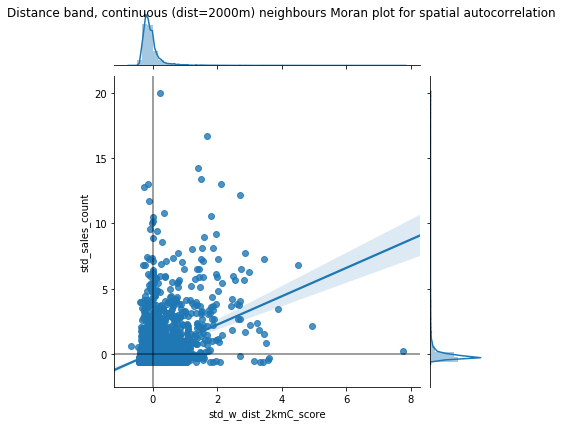

In [76]:
plot_moran(teranet_da_gdf['std_w_dist_2kmC_score'], teranet_da_gdf[std_col], 
           plot_title="Distance band, continuous (dist=2000m) neighbours")

In [87]:
t_da_gdf_noisl[std_col] = standardize(t_da_gdf_noisl[column])
std_dist2kmC_ni_score = ps.lib.weights.lag_spatial(w_dist2kmC_ni, 
                                                   t_da_gdf_noisl[std_col])
t_da_gdf_noisl['std_w_dist_2kmC_ni_score'] = std_dist2kmC_ni_score

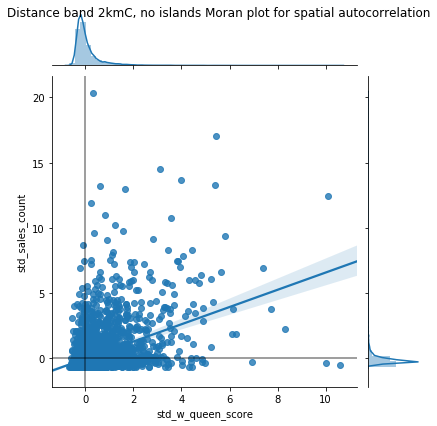

In [89]:
plot_moran(t_da_gdf_noisl['std_w_queen_score'], t_da_gdf_noisl[std_col], plot_title="Distance band 2kmC, no islands")

### Moran's I

The Moran Plot is an excellent tool to explore the data and get a good sense of how much values are clustered over space. However, because it is a graphical device, it is sometimes hard to condense its insights into a more concise way. For these cases, a good approach is to come up with a statistical measure that summarizes the figure. This is exactly what Moran's I is meant to do. 

Very much in the same way the mean summarizes a crucial element of the distribution of values in a non-spatial setting, so does Moran's I for a spatial dataset. Continuing the comparison, we can think of the mean as a single numerical value summarizing a histogram or a kernel density plot. Similarly, Moran's I captures much of the essence of the Moran Plot. In fact, there is an even close connection between the two: the value of Moran's I corresponds with the slope of the linear fit overlayed on top of the Moran Plot.

In [106]:
mi_queen = moran_i(teranet_da_gdf[column], w_queen, title="Queen neighbours")

Moran I for Queen neighbours
Moran I value = 0.2952150163930997
Associated p-value = 0.001


In [107]:
mi_knn = moran_i(teranet_da_gdf[column], knn, title="KNN (k={0}) neighbours".format(k))

Moran I for KNN (k=20) neighbours
Moran I value = 0.15630281749839545
Associated p-value = 0.001


In [111]:
mi_dist1kmB = moran_i(teranet_da_gdf[column], w_dist1kmB, title="Distabce band, binary (dist=1000m) neighbours")

Moran I for Distabce band, binary (dist=1000m) neighbours
Moran I value = 0.1964086739886229
Associated p-value = 0.001


In [112]:
mi_dist2kmB = moran_i(teranet_da_gdf[column], w_dist2kmB, title="Distabce band, binary (dist=2000m) neighbours")

Moran I for Distabce band, binary (dist=2000m) neighbours
Moran I value = 0.11220790733789433
Associated p-value = 0.001


In [113]:
mi_dist1kmC = moran_i(teranet_da_gdf[column], w_dist1kmC, title="Distabce band, continuous (dist=1000m) neighbours")

Moran I for Distabce band, continuous (dist=1000m) neighbours
Moran I value = 0.20540626542535528
Associated p-value = 0.001


In [114]:
mi_dist2kmC = moran_i(teranet_da_gdf[column], w_dist2kmC, title="Distabce band, continuous (dist=2000m) neighbours")

Moran I for Distabce band, continuous (dist=2000m) neighbours
Moran I value = 0.14189205401921104
Associated p-value = 0.001


In [116]:
mi_dist2kmC_ni = moran_i(t_da_gdf_noisl[column], w_dist2kmC_ni, title="Distabce band, continuous (dist=2000m) neighbours, no islands")

Moran I for Distabce band, continuous (dist=2000m) neighbours, no islands
Moran I value = 0.14581331442464876
Associated p-value = 0.001


What that 0.001 (or 0.1%) means is that, if we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran's I statistic for each of those maps, only 0.1% of them would display a larger (absolute) value than the one we obtain from the real data, and the other 99.9% of the random maps would receive a smaller (absolute) value of Moran's I. If we remember again that the value of Moran's I can also be interpreted as the slope of the Moran Plot, what we have is that, in this case, the particular spatial arrangement of values for the Leave votes is more concentrated than if the values had been allocated following a completely spatially random process, hence the statistical significance.

### Local Spatial autocorrelation

Moran's I is good tool to summarize a dataset into a single value that informs about its degree of *clustering*. However, it is not an appropriate measure to identify areas within the map where specific values are located. In other words, Moran's I can tell us values are clustered overall, but it will not inform us about *where* the clusters are. For that purpose, we need to use a *local* measure of spatial autocorrelation. Local measures consider each single observation in a dataset and operate on them, as oposed to on the overall data, as *global* measures do. Because of that, they are not good a summarizing a map, but they allow to obtain further insight.

We will consider [Local Indicators of Spatial Association](http://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.1995.tb00338.x/abstract) (LISAs), a local counter-part of global measures like Moran's I. At the core of these method is a classification of the observations in a dataset into four groups derived from the Moran Plot: high values surrounded by high values (HH), low values nearby other low values (LL), high values among low values (HL), and viceversa (LH). Each of these groups are typically called "quadrants". An illustration of where each of these groups fall into the Moran Plot can be seen below:

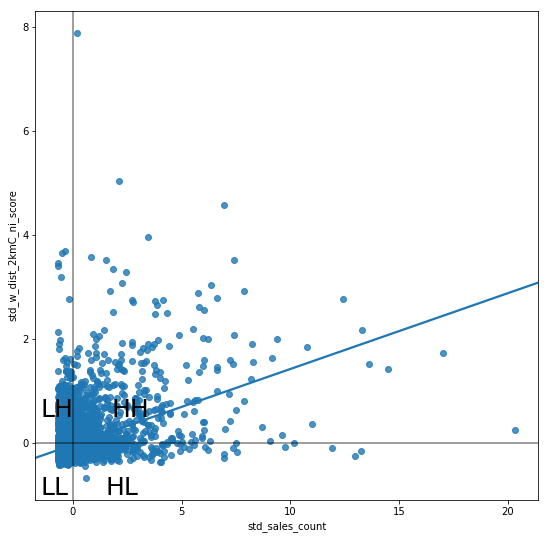

In [124]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=std_col, y='std_w_dist_2kmC_ni_score', 
            data=t_da_gdf_noisl, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.75, 0.5, "HH", fontsize=25)
plt.text(1.5, -1, "HL", fontsize=25)
plt.text(-1.5, 0.5, "LH", fontsize=25)
plt.text(-1.5, -1, "LL", fontsize=25)
# Display
plt.show()

So far we have classified each observation in the dataset depending on its value and that of its neighbors. This is only half way into identifying areas of unusual concentration of values. To know whether each of the locations is a *statistically significant* cluster of a given kind, we again need to compare it with what we would expect if the data were allocated in a completely random way. After all, by definition, every observation will be of one kind of another, based on the comparison above. However, what we are interested in is whether the strength with which the values are concentrated is unusually high. 

This is exactly what LISAs are designed to do. The core idea is to identify cases in which the comparison between the value of an observation and the average of its neighbors is either more similar (HH, LL) or dissimilar (HL, LH) than we would expect from pure chance. The mechanism to do this is similar to the one in the global Moran's I, but applied in this case to each observation, resulting then in as many statistics as original observations.

LISAs are widely used in many fields to identify clusters of values in space. They are a very useful tool that can quickly return areas in which values are concentrated and provide *suggestive* evidence about the processes that might be at work. For that, they have a prime place in the exploratory toolbox. Examples of contexts where LISAs can be useful include: identification of spatial clusters of poverty in regions, detection of ethnic enclaves, delineation of areas of particularly high/low activity of any phenomenon, etc.

In [128]:
lisa_dist2kmC_ni = ps.explore.esda.moran.Moran_Local(t_da_gdf_noisl[column], w_dist2kmC_ni)

In [144]:
lisa_queen = ps.explore.esda.moran.Moran_Local(teranet_da_gdf[column], w_queen)

C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\pysal\explore\esda\moran.py:895: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\scipy\stats\_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


Because of their very nature, looking at the numerical result of LISAs is not always the most useful way to exploit all the information they can provide. As we are calculating a statistic for every sigle observation in the data so, if we have many of them, it will be difficult to extract any meaningful pattern. Instead, what is typically done is to create a map, a cluster map as it is usually called, that extracts the significant observations (those that are highly unlikely to have come from pure chance) and plots them with a specific color depending on their quadrant category.

In [129]:
# Break observations into significant or not
t_da_gdf_noisl['significant'] = lisa_dist2kmC_ni.p_sim < 0.05
# Store the quadrant they belong to
t_da_gdf_noisl['quadrant'] = lisa_dist2kmC_ni.q

In [145]:
# Break observations into significant or not
teranet_da_gdf['significant'] = lisa_queen.p_sim < 0.05
# Store the quadrant they belong to
teranet_da_gdf['quadrant'] = lisa_queen.q

Similarly as with global Moran's I, `PySAL` is automatically computing a p-value for each LISA. Because not every observation represents a statistically significant one, we want to identify those with a p-value small enough that rules out the possibility of obtaining a similar situation from pure chance. Following a similar reasoning as with global Moran's I, we select 5% as the threshold for statistical significance.

Variable `quadrant` identifies the quadrant each observation belongs to. The correspondence between the numbers in the variable and the actual quadrants is as follows:

* 1: HH
* 2: LH
* 3: LL
* 4: HL

With these two elements, `significant` and `quadrant`, we can build a typical LISA cluster map:

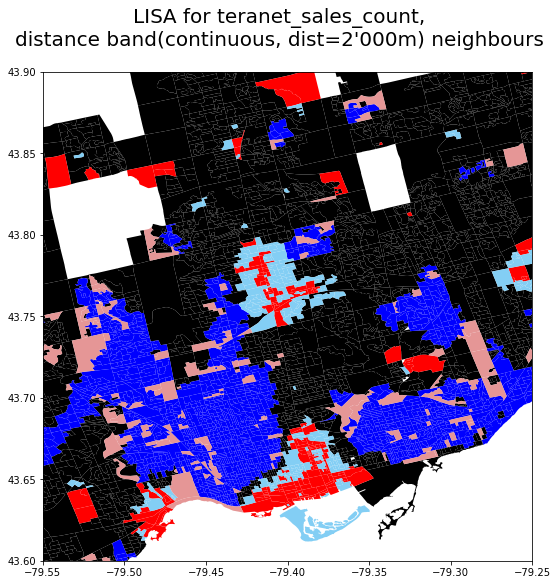

In [158]:
map_lisa(t_da_gdf_noisl, left_lim=-79.55, bottom_lim=43.6, zoom=0.3,
        plot_title=" for " + column + ",\ndistance band(continuous, dist=2'000m) neighbours")

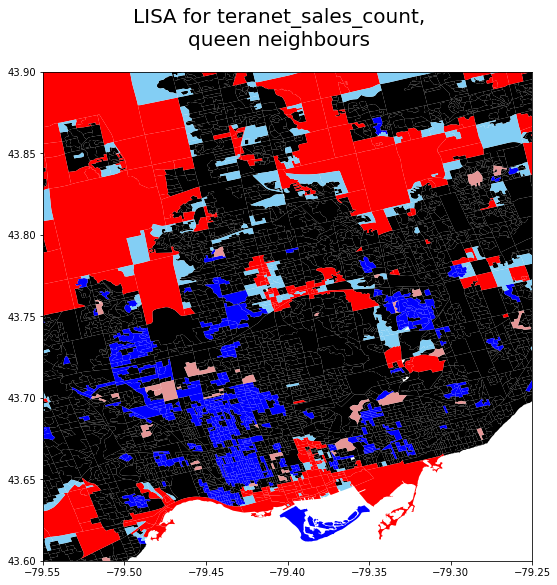

In [160]:
map_lisa(teranet_da_gdf, left_lim=-79.55, bottom_lim=43.6, zoom=0.3,
        plot_title=" for " + column + ',\nqueen neighbours')

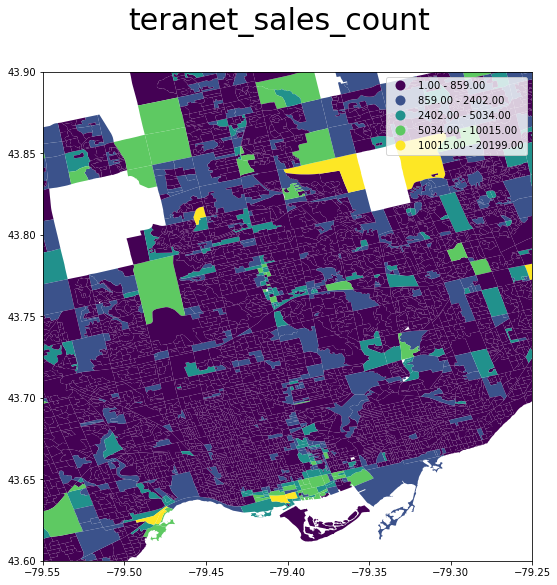

In [162]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
t_da_gdf_noisl.plot(column=column, scheme='fisher_jenks',
                    legend=True, ax=ax)
f.suptitle(column, size=30)
f.set_facecolor('white')
left_lim = -79.55
bottom_lim = 43.6
zoom = 0.3
ax.set_xlim(left_lim, left_lim + zoom)
ax.set_ylim(bottom_lim, bottom_lim + zoom)
plt.show()

In bright red, we find those local authorities with an unusual concentration of high values surrounded also by high values. In light red, we find the first type of *spatial outliers*. These are areas with high values but surrounded by areas with low values. Finally, in light blue we find the other type of spatial outlier: DAs with low values surrounded by other DAs with high values.

The substantive interpretation of a LISA map needs to relate its output to the original intention of the analyst who created the map. In this case, our original idea was to explore the spatial structure of Teranet sales counts per DA. The LISA proves a fairly useful tool in this context. Comparing the LISA map above with the choropleth, we can interpret the LISA as "simplification" of the detailed but perhaps too complicated picture in the choropleth that focuses the reader's attention to the areas that display a particularly high concentration of (dis)similar values, helping the spatial structure of the distribution emerge in a more explicit way.

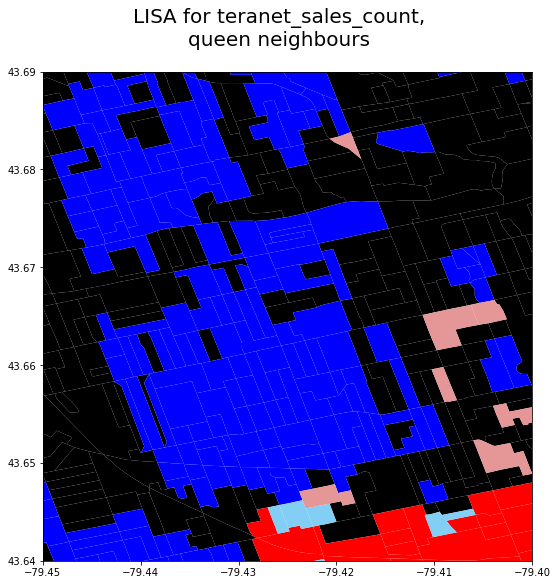

In [165]:
map_lisa(teranet_da_gdf, left_lim=-79.45, bottom_lim=43.64, zoom=0.05,
        plot_title=" for " + column + ',\nqueen neighbours')

In [77]:
teranet_da_gdf.crs

{'init': 'epsg:4326'}

In [78]:
from pyproj import Proj
Proj('+init=epsg:2193', preserve_flags=True)

pyproj.Proj('+units=m +init=epsg:2193', preserve_units=True)

In [24]:
Pr0oj({'init': 'epsg:2193', 'no_defs': True}, preserve_flags=True)

RuntimeError: b'no arguments in initialization list'

In [22]:
data = teranet_da_gdf.to_crs(epsg=27700)
data.crs

RuntimeError: b'no arguments in initialization list'

In [61]:
# combine values in columns 'x' and 'y' into a POINT geometry object
geometry = [Point(xy) for xy in zip(teranet_da_df['x'], teranet_da_df['y'])]
# generate a new GeoDataFrame by adding point geometry to data frame 'teranet_sales_data'
point_data = gpd.GeoDataFrame(teranet_da_df, geometry=geometry)
print("Geometry generated from 'x' and 'y' pairs, GeoDataFrame created!")

Geometry generated from 'x' and 'y' pairs, GeoDataFrame created!


In [67]:
%%time
# add CRS for WGS84 (lat-long) to GeoDataFrame 'sales_data_geo'
point_data.crs = {'proj': 'latlong', 
                  'ellps': 'WGS84', 
                  'datum': 'WGS84', 
                  'no_defs': True}
points_data = point_data.to_crs(epsg=27700)
point_data.crs

Wall time: 6min 2s


In [ ]:
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
data.plot(ax=ax, facecolor='k', linewidth=0.1)
# plot point data
point_data.head(1000).plot(ax=ax)
# Title
f.suptitle("Sample of Teranet sales with DAs")
# Style and display on screen
y_lim = 3056000
x_lim = -5130000
step = 5000
# ax.set_ylim(y_lim, y_lim + step)
# ax.set_xlim(x_lim, x_lim + step)
plt.show()

In [66]:
%%time
w_point_dist1kmC = ps.lib.weights.DistanceBand.from_dataframe(point_data, 
                                                        1000, 
                                                        binary=False)
w_point_dist1kmC


ValueError: Could not make array from data